# Epipolar_Geometry.ipynb
__Description:__ Notebook details how to answer questions for section 2.2.<br>
__Author:__ Matthew Lesko-Krleza<br>
__Course:__ ECSE 415<br>
__Assignment:__ Assignment #3

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_left = cv2.cvtColor(cv2.imread('./Aloe/view1.png'), cv2.COLOR_BGR2RGB)
img_right = cv2.cvtColor(cv2.imread('./Aloe/view5.png'), cv2.COLOR_BGR2RGB)

In [2]:
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

### Question 2 Stereo Vision

#### Question 2.2 Epipolar Geometry

Question 2.2.1 Compute matching SIFT keypoints from a stereo image pair

In [3]:
sift_obj = cv2.xfeatures2d.SIFT_create()
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

keypoints_left, descriptors_left = sift_obj.detectAndCompute(img_left, None)
keypoints_right, descriptors_right = sift_obj.detectAndCompute(img_right, None)

img_keypoints_left = img_left.copy()
img_keypoints_right = img_right.copy()

img_keypoints_left = cv2.drawKeypoints(img_left, keypoints_left, img_keypoints_left, 
                  flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_keypoints_right = cv2.drawKeypoints(img_right, keypoints_right, img_keypoints_right, 
                  flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

matches = bfMatcher.knnMatch(descriptors_left, descriptors_right, k=2)

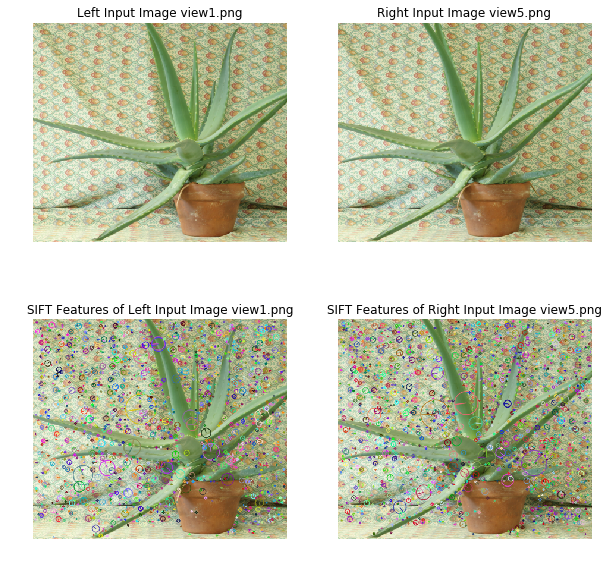

In [4]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(img_left)
plt.title("Left Input Image view1.png"), plt.axis('off')
plt.subplot(222)
plt.imshow(img_right)
plt.title("Right Input Image view5.png"), plt.axis('off')
plt.subplot(223)
plt.imshow(img_keypoints_left)
plt.title("SIFT Features of Left Input Image view1.png"), plt.axis('off')
plt.subplot(224)
plt.imshow(img_keypoints_right)
plt.title("SIFT Features of Right Input Image view5.png"), plt.axis('off')
plt.show()

Question 2.2.2 Compute epipolar lines for both images

In [5]:
img_left_grey = cv2.cvtColor(img_left.copy(), cv2.COLOR_RGB2GRAY)
img_right_grey = cv2.cvtColor(img_right.copy(), cv2.COLOR_RGB2GRAY)

# ratio test - store the list of best matches from both images
good = []
bad = []
points_right = []
points_left = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.5 * n.distance:
        good.append(m)
        points_right.append(keypoints_right[m.trainIdx].pt)
        points_left.append(keypoints_left[m.queryIdx].pt)

# find the Fundamental Matrix
points_left = np.int32(points_left)
points_right = np.int32(points_right)

F, mask = cv2.findFundamentalMat(points_left, points_right, cv2.FM_LMEDS)

# Use only inliers for remaining computations
points_left_bad = points_left
points_right_bad = points_right
points_left = points_left[mask.ravel()==1]
points_right = points_right[mask.ravel()==1]

points_left_bad = points_left_bad[mask.ravel()==0]
points_right_bad = points_right_bad[mask.ravel()==0]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
lines_left = cv2.computeCorrespondEpilines(points_right, 2, F)
lines_left = lines_left.reshape(-1, 3)
# draw lines
img_left1, img_right1 = drawlines(img_left_grey, img_right_grey, lines_left, points_left, points_right)

lines_right = cv2.computeCorrespondEpilines(points_left, 1, F)
lines_right = lines_right.reshape(-1, 3)
# draw lines
img_right2, img_left2 = drawlines(img_right_grey, img_left_grey, lines_right, points_right, points_left)

Display epipolar lines for both images

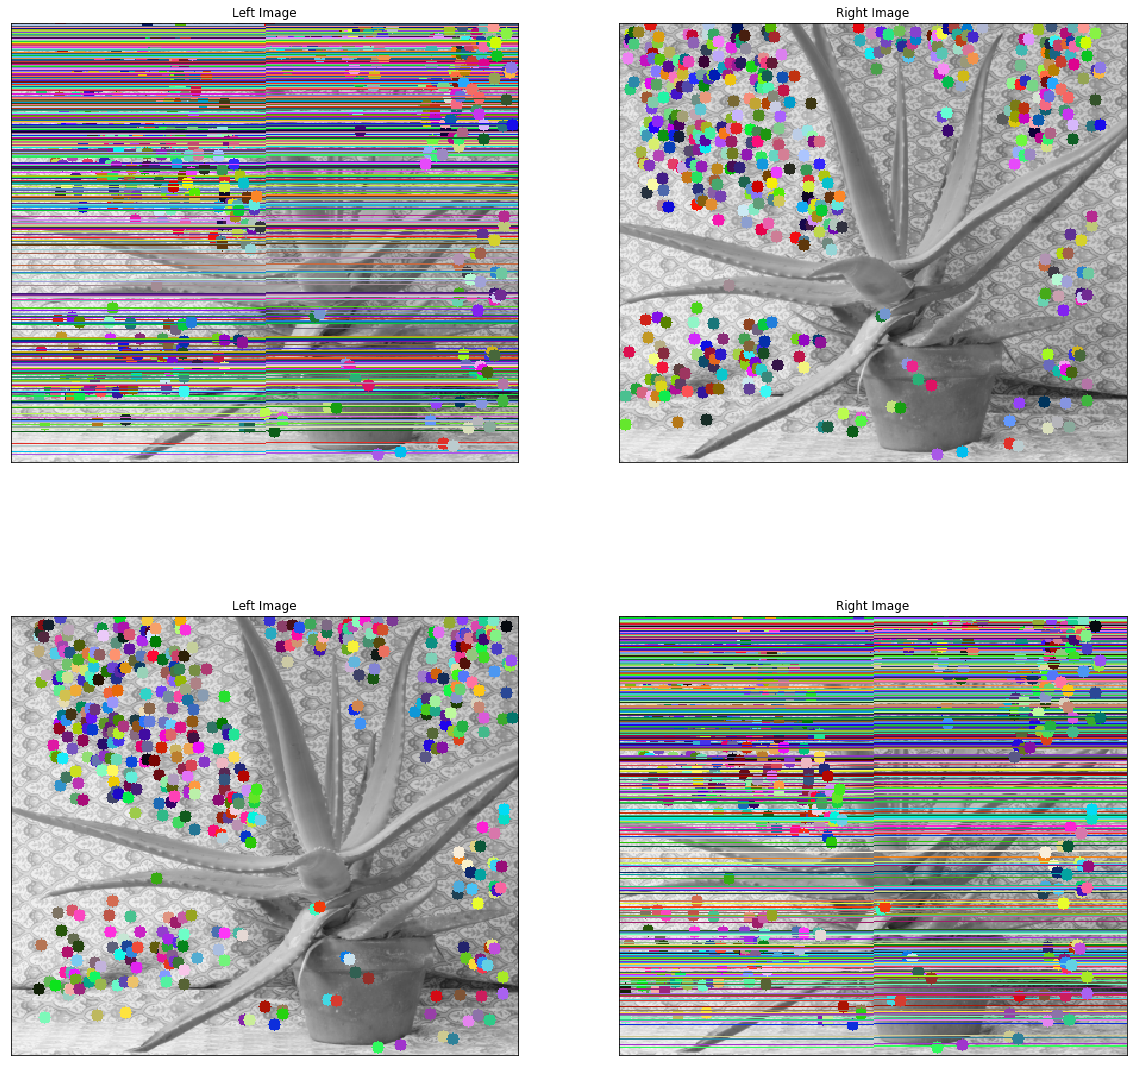

In [6]:
plt.figure(figsize=(20, 20))
plt.subplot(221), plt.imshow(img_left1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(img_right1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(img_left2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(img_right2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

Question 2.2.3 Pick any one keypoint in the right image which doesn't have a correct match in the left image, and is not on the corresponding epipolar line. Extract a patch of size (5 x 5) around the keypoint in the right image.

I've decided to use the outliers to find an incorrect keypoint

In [7]:
def extractPatch(x, y, img):
    return img[y - 2 : y + 3, x - 2 : x + 3]

def computeSSD(a, b):
    return np.float64(np.sum((a - b) ** 2))

In [8]:
# I've chosen this incorrect point randomly
incorrect_point = 1

x_right, y_right = points_right[incorrect_point]
print(x_right, y_right)

patch_right = extractPatch(x_right, y_right, img_right_grey)
print(patch_right)

5 314
[[156 138 140 160 165]
 [121 144 161 168 173]
 [188 205 211 212 216]
 [192 192 199 212 204]
 [180 183 203 191 173]]


Question 2.2.4 Match the extracted patch using SSD with every patch along the corresponding epipolar line in the left image.

In [9]:
patch_ssd = []

for x in range(2, img_left.shape[1] - 2):
    y = int(lines_left[incorrect_point, 0] * x + lines_left[incorrect_point, 2])
    patch_left = extractPatch(x, y, img_left_grey)
    patch_ssd.append(computeSSD(patch_left, patch_right))

Question 2.2.5 Plot SSD values. Find the matching point with minimum SSD value.

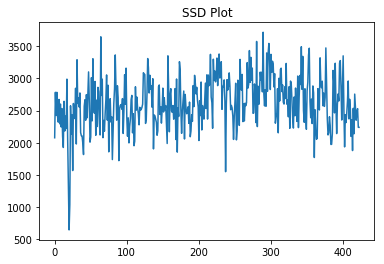

Minimum SSD value:	644.0
Left Image:	(22, 314) 	 Right image:	(5, 314)


In [10]:
img_display_left = img_left.copy()
img_display_right = img_right.copy()

plt.title("SSD Plot")
plt.plot(patch_ssd)
plt.show()

# argmin is offset by 2 compared to real x value
min_left_x = np.argmin(patch_ssd) + 2
min_left_y = int(lines_left[incorrect_point, 0] * min_left_x + lines_left[incorrect_point, 2])

print(str.format("Minimum SSD value:\t{}", np.min(patch_ssd) ))
print(str.format("Left Image:\t({}, {}) \t Right image:\t({}, {})", min_left_x, min_left_y, x_right, y_right))

Display found matching points in both images.

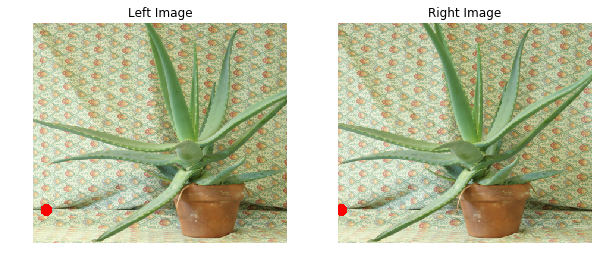

In [11]:
img_display_left = cv2.circle(img_display_left, (min_left_x, min_left_y), 10, (255, 0, 0), -1)
img_display_right = cv2.circle(img_display_right, (x_right, y_right), 10, (255, 0, 0), -1)

plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(img_display_left)
plt.title("Left Image"), plt.axis('off')
plt.subplot(122), plt.imshow(img_display_right)
plt.title("Right Image"), plt.axis('off')
plt.show()

#### Question 2.2.5 Did you find exactly one matching point with lowest SSD or multiple? Is the found matching point correct one? Explain why.

I found exactly one matching. As you can see the left and right images' coordinates, their y coordinates don't differ whatsoever. Considering that the epilines are entirely straight, these facts imply that the two points are on the same epipolar line. Also a difference of 17 in their x coordinates implies that the right image's camera was translated to the right by 17 pixels. These facts are consistent with the resulting epipolar lines, and with the fact that the right image is a horizontal translation of the left image.

#### Question 2.2.6 Suppose you found multiple matches in the previous question. What constraint(s) could be imposed on the matching algorithm to find a single matching point?

Instead of using SSD to determine the most similar point by identifying the least SSD, one could solve the multiple match problem by treating it as an energy minimization. Each pixel has a match cost defined by E(d) = E_d(d) + lE_s(d), and the problem then simplifies to minimizing this function.

Supposing I found multiple matches, then I could smoothen out the image. By smoothing the image, the disparity is smootly varying. One could define the smoothness cost as the sum of some potential function from neighboring pixels. One could define the potential function as either a distance function, quadratic function, L1 function, etc. If you have smooth disparity, then this smoothness cost is low. You therefore disregard patches with high contrast. You would more accurately identify matches.

#### Question 2.2.7 Suppose you found exactly one match with the lowest SSD, but it is incorrect one. What constraint(s) could be imposed to find a correct match?

You could impose a locality constraint. The point corresponding to your lowest SSD would have to stay within a threshold of the initial point. This threshold could be approximated by knowing the degree of change in translation and/or rotation of the camera for the second image.